# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline

pd.set_option('display.max_columns',200)
pd.set_option("display.max_info_rows", 800)
pd.set_option('display.max_info_columns',800)

from sklearn import set_config
set_config(transform_output='pandas')


import warnings
warnings.filterwarnings("ignore")



from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

In [3]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
    # Get the classification report
    report = classification_report(y_true, y_pred)
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    # create a confusion matrix  of raw counts
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
    axes[0].set_title("Raw Counts")
    # create a confusion matrix with the test data
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict


def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
    # Get predictions for training data
    y_train_pred = model.predict(X_train)
    # Call the helper function to obtain regression metrics for training data
    results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
    print()
    # Get predictions for test data
    y_test_pred = model.predict(X_test)
    # Call the helper function to obtain regression metrics for test data
    results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
    if output_dict == True:
        # Store results in a dataframe if ouput_frame is True
        results_dict = {'train':results_train,
                    'test': results_test}
        return results_dict

# Loading data 

In [4]:
# Get Data
df = pd.read_csv('Metabolic  Syndrome.csv')
df.head()

,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
1,62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
2,62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn
3,62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn
4,62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,No MetSyn


# Explore Data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   seqn               int64  
 1   Age                int64  
 2   Sex                object 
 3   Marital            object 
 4   Income             float64
 5   Race               object 
 6   WaistCirc          float64
 7   BMI                float64
 8   Albuminuria        int64  
 9   UrAlbCr            float64
 10  UricAcid           float64
 11  BloodGlucose       int64  
 12  HDL                int64  
 13  Triglycerides      int64  
 14  MetabolicSyndrome  object 
dtypes: float64(5), int64(6), object(4)
memory usage: 281.5+ KB


In [6]:
df.isna().sum()#.sum()

seqn                   0
Age                    0
Sex                    0
Marital              208
Income               117
Race                   0
WaistCirc             85
BMI                   26
Albuminuria            0
UrAlbCr                0
UricAcid               0
BloodGlucose           0
HDL                    0
Triglycerides          0
MetabolicSyndrome      0
dtype: int64

In [7]:
df.isna().sum()/len(df)*100

seqn                 0.000000
Age                  0.000000
Sex                  0.000000
Marital              8.663057
Income               4.872970
Race                 0.000000
WaistCirc            3.540192
BMI                  1.082882
Albuminuria          0.000000
UrAlbCr              0.000000
UricAcid             0.000000
BloodGlucose         0.000000
HDL                  0.000000
Triglycerides        0.000000
MetabolicSyndrome    0.000000
dtype: float64

In [8]:
df['MetabolicSyndrome'].value_counts()/len(df)*100

No MetSyn    65.764265
MetSyn       34.235735
Name: MetabolicSyndrome, dtype: float64

In [9]:
df.shape

(2401, 15)

---

- My Target would be : MetabolicSyndrome
- Each Row represents : A Person
- Number of Features The Dataframe includes : 15 
- Number of Row the Dataframe includes : 2401
- The Target's Values are not balanced, we will be using a Balancing method (Smote)
- Initially, we will be using all of the 15 features, and test importance later on
- we have a total of 436 missing values that we will need to impute during our modeling
    
---

# Basic Visualization

## needed function for visualization

In [10]:
# Updating function
def plot_categorical_vs_target(df, x, y, figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None, target_type='reg'):
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)
  # REGRESSION-TARGET PLOT

#old function did not have an if statement ---------------------------- to make a histoplot for 'class'

  if target_type=='reg': #Added if statement here
    # Barplot
    sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
                linewidth=1, edgecolor='black', errorbar=None)
    # Boxplot
    sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                  order=order, hue_order=order, legend=False,
                  edgecolor='white', linewidth=0.5,
                  size=3,zorder=0)
  # CLASSIFICATION-TARGET PLOT # This is the new code for the classification task
  elif target_type=='class':
    ax = sns.histplot(data=temp_df, hue=y, x=x, stat='percent',  multiple='fill')
  # Rotate xlabels
  ax.set_xticks(ax.get_xticks()) # Added this to prevent a bug
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax



In [11]:
# Updating the function
def plot_numeric_vs_target(df, x, y, figsize=(6,4),
                           target_type='reg', estimator='mean',
                           errorbar='ci',sorted=False , ascending=False,
                           **kwargs): # kwargs for sns.regplot

  nulls = df[[x,y]].isna().sum()
  if nulls.sum()>0:
    print(f"- Excluding {nulls.sum()} NaN's")
    # print(nulls)
    temp_df = df.dropna(subset=[x,y,])
  else:
    temp_df = df

    
  # Create the figure
  fig, ax = plt.subplots(figsize=figsize)

  # REGRESSION-TARGET PLOT
  if 'reg' in target_type:
    # Calculate the correlation
    corr = df[[x,y]].corr().round(2)
    r = corr.loc[x,y]
    # Plot the data
    scatter_kws={'ec':'white','lw':1,'alpha':0.8}
    sns.regplot(data=temp_df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs) # Included the new argument within the sns.regplot function
    ## Add the title with the correlation
    ax.set_title(f"{x} vs. {y} (r = {r})")

  # CLASSIFICATION-TARGET PLOT
  elif 'class' in target_type:

    # Sort the groups by median/mean
    if sorted == True:

      if estimator == 'median':
        group_vals = temp_df.groupby(y)[x].median()
      elif estimator =='mean':
        group_vals = temp_df.groupby(y)[x].mean()

      ## Sort values
      group_vals = group_vals.sort_values(ascending=ascending)
      order = group_vals.index

    else:
      # Set order to None if not calcualted
      order = None


    # Left Subplot (barplot)
    sns.barplot(data=temp_df, x=y, y=x, order=order,  estimator=estimator,
                errorbar=errorbar, ax=ax, **kwargs)

    # Add title
    ax.set_title(f"{x} vs. {y}")

    # rotate xaxis labels
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


  # Final Adjustments & return
  fig.tight_layout()
  fig.show()
  return fig, ax


## Visualization

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Marital vs. MetabolicSyndrome'}, xlabel='Marital', ylabel='Percent'>)

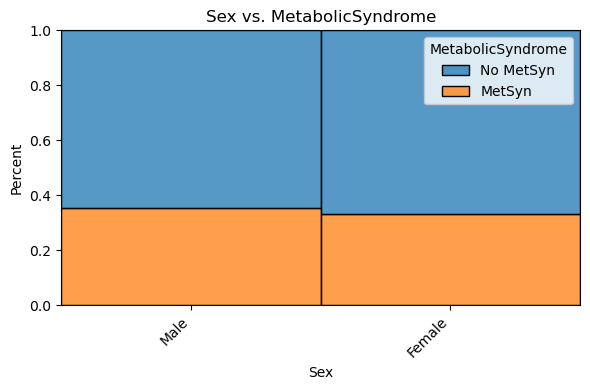

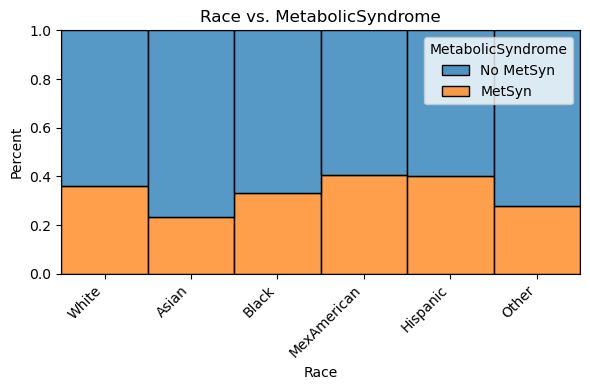

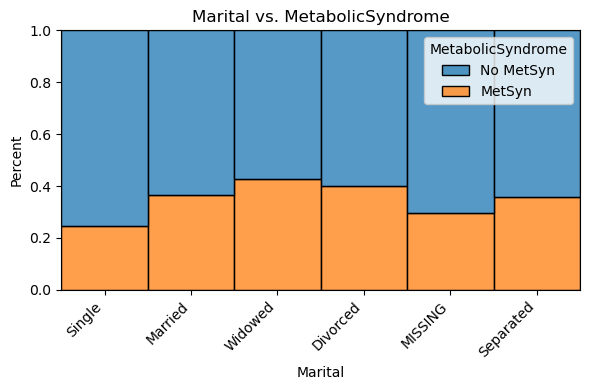

In [12]:
plot_categorical_vs_target(df, 'Sex', 'MetabolicSyndrome', target_type='class')

plot_categorical_vs_target(df, 'Race', 'MetabolicSyndrome', target_type='class')

plot_categorical_vs_target(df, 'Marital', 'MetabolicSyndrome', target_type='class')

---

- we cannot explore alot from these plots, but from the fight sight we can say that the only statement we can be sure of, is that Asians(race) and single people(martial status) tend to have less probability to have metabolic syndrome than other categories we have in out data


---

- Excluding 117 NaN's
- Excluding 26 NaN's


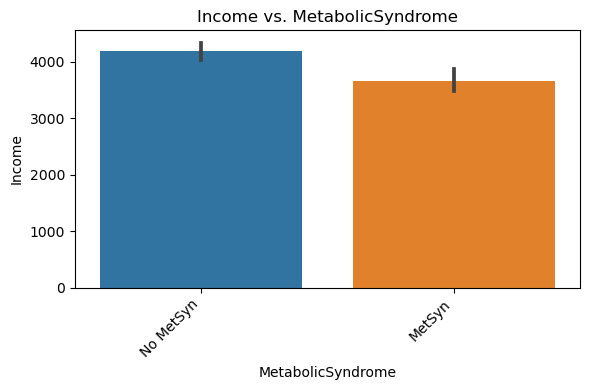

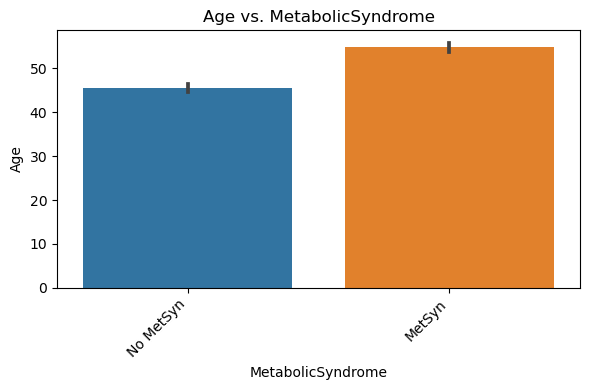

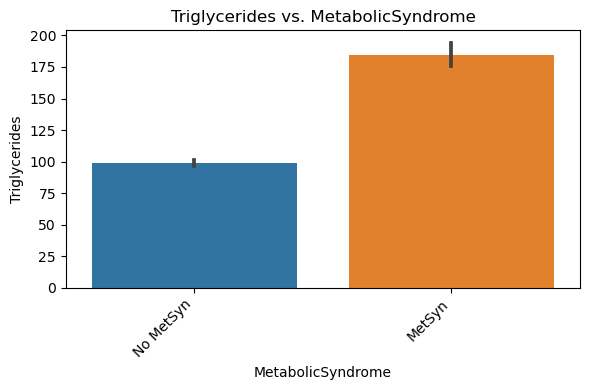

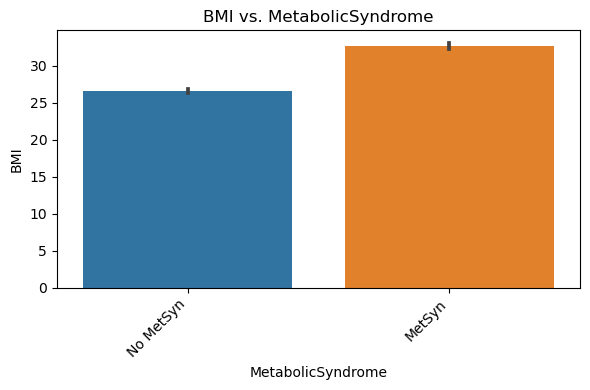

In [13]:
plot_numeric_vs_target(df,'Income','MetabolicSyndrome', target_type='class');
plot_numeric_vs_target(df,'Age','MetabolicSyndrome', target_type='class');
plot_numeric_vs_target(df,'Triglycerides','MetabolicSyndrome', target_type='class');
plot_numeric_vs_target(df,'BMI','MetabolicSyndrome', target_type='class');

---

- from the first glance we can tell from the three examples we've chosen to explore, that higher income, younger people, people with less Triglycerides & people with lower body mass index (BMI) tend to have a lower chance of having metabolic according to this dataset


---

# preprocessing & transforming data

In [14]:
df = df.set_index('seqn')
df.head()

,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
seqn,,,,,,,,,,,,,,
62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn
62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn
62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,No MetSyn


In [15]:


# Define features and target
X = df.drop(columns = 'MetabolicSyndrome')
y = df['MetabolicSyndrome']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [16]:
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)

impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()

num_pipe = make_pipeline(impute_median, scaler)


Numeric Columns: Index(['Age', 'Income', 'WaistCirc', 'BMI', 'Albuminuria', 'UrAlbCr',
       'UricAcid', 'BloodGlucose', 'HDL', 'Triglycerides'],
      dtype='object')


In [17]:
num_tuple = ('numeric', num_pipe, num_cols)
num_tuple

# ('title', pipe , cols)

('numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 Index(['Age', 'Income', 'WaistCirc', 'BMI', 'Albuminuria', 'UrAlbCr',
        'UricAcid', 'BloodGlucose', 'HDL', 'Triglycerides'],
       dtype='object'))

In [18]:
ohe_cols = make_column_selector(dtype_include='object')

print("OneHotEncoder Columns:", ohe_cols)

impute_na = SimpleImputer(strategy='most_frequent')

ohe_encoder = OneHotEncoder(drop = 'first', sparse=False)  

ohe_pipe = make_pipeline(impute_na, ohe_encoder)
ohe_pipe

OneHotEncoder Columns: <sklearn.compose._column_transformer.make_column_selector object at 0x0000023540258E80>


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder', OneHotEncoder(drop='first', sparse=False))])

In [19]:
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)
ohe_tuple

#title, pipe, cols

('categorical',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('onehotencoder', OneHotEncoder(drop='first', sparse=False))]),
 <sklearn.compose._column_transformer.make_column_selector at 0x23540258e80>)

In [20]:
preprocessor = ColumnTransformer([num_tuple, ohe_tuple], verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Age', 'Income', 'WaistCirc', 'BMI', 'Albuminuria', 'UrAlbCr',
       'UricAcid', 'BloodGlucose', 'HDL', 'Triglycerides'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000023540258E80>)],
                  verbose_feature_names_out=False)

In [21]:
preprocessor.fit(X_train)

X_train_tf = preprocessor.transform(X_train)

X_test_tf = preprocessor.transform(X_test)

X_train_tf.head()

,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,Sex_Male,Marital_Married,Marital_Separated,Marital_Single,Marital_Widowed,Race_Black,Race_Hispanic,Race_MexAmerican,Race_Other,Race_White
seqn,,,,,,,,,,,,,,,,,,,,
63211,-0.176875,1.443579,1.591313,1.815754,-0.366397,-0.100646,-1.503810,0.962189,-0.045041,0.728110,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
70548,-0.857407,-0.165173,-0.767163,-0.637064,-0.366397,-0.108892,0.406271,0.185052,1.929154,-0.704544,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
64722,-0.914117,-0.165173,-1.465971,-0.561824,-0.366397,-0.125171,-1.435593,-0.323077,-0.637299,-0.704544,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
69237,-0.006742,1.717409,-0.174425,0.687157,-0.366397,-0.152526,-1.913113,-0.562196,-0.176654,0.115599,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
65286,-1.084250,1.717409,-1.422296,-1.028311,-0.366397,-0.138548,1.088443,-0.801315,0.283992,2.762893,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modeling: KNN Classification Model

- Disclaimer: 

**the best treatment for metabolic syndrom is a healthy diet and exercise, which is the first treatment when the results are ambiguous but also pointing at a probable metabolic syndrome, hense we here are interested in recallability of the model, to get as much true positives and as less false negatives.**


---

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sampler_pipeline


## KNN default model

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.86      0.75      0.80       618
   No MetSyn       0.88      0.93      0.90      1182

    accuracy                           0.87      1800
   macro avg       0.87      0.84      0.85      1800
weighted avg       0.87      0.87      0.87      1800



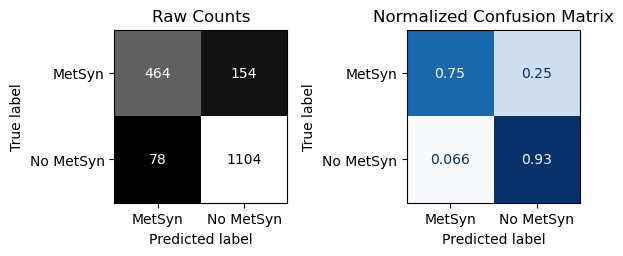


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.71      0.60      0.65       204
   No MetSyn       0.81      0.88      0.84       397

    accuracy                           0.78       601
   macro avg       0.76      0.74      0.75       601
weighted avg       0.78      0.78      0.78       601



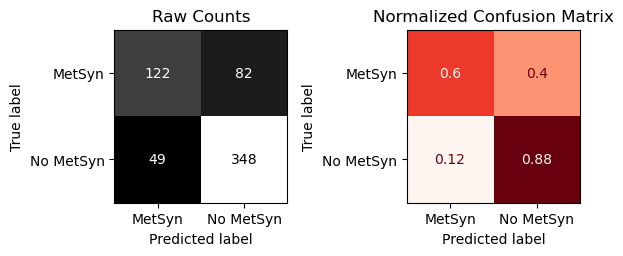

In [23]:

knn = KNeighborsClassifier()


knn_pipe = make_pipeline(preprocessor, knn)

knn_pipe.fit(X_train, y_train)


evaluate_classification(knn_pipe, X_train, y_train, X_test, y_test)

In [24]:
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Age', 'Income', 'WaistCirc', 'BMI', 'Albuminuria', 'UrAlbCr',
       'UricAcid', 'BloodGlucose', 'HDL', 'Triglycerides'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000023540258E80>)],
                  verbose_feature_names_out=False)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.75      0.92      0.82       618
   No MetSyn       0.95      0.84      0.89      1182

    accuracy                           0.87      1800
   macro avg       0.85      0.88      0.86      1800
weighted avg       0.88      0.87      0.87      1800



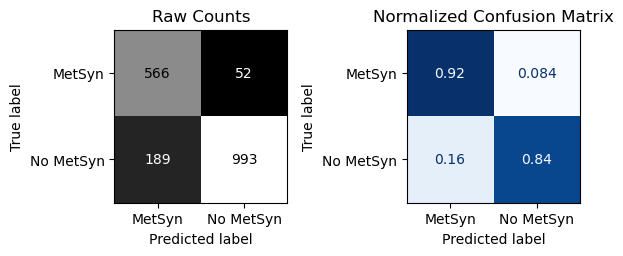


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.63      0.78      0.70       204
   No MetSyn       0.87      0.77      0.82       397

    accuracy                           0.77       601
   macro avg       0.75      0.78      0.76       601
weighted avg       0.79      0.77      0.78       601



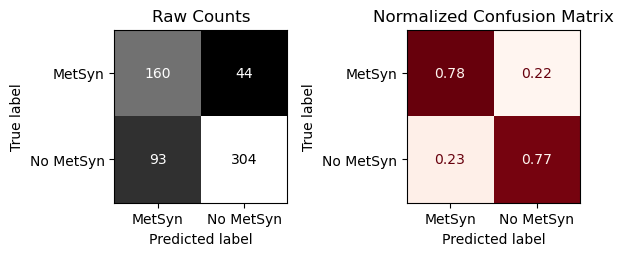

In [25]:
smote = SMOTE(random_state=42)

knn_smote_pipe = make_sampler_pipeline(preprocessor, smote,  knn)

knn_smote_pipe.fit(X_train, y_train)

evaluate_classification(knn_smote_pipe, X_train, y_train, X_test, y_test)

In [26]:
# knn_smote_pipe.get_params()

- the decision is to further work with smote in this situation since it gives better results based on our goal which are:
  - higher recall (higher true positive)
  - this method gives more false positive results that we are willing to accept (from 16% increase to 23%)
  - this method decreases the false negative results from 40% to 22% which is crucial to our goal

- we will have to tune the model more to get better results but this seems as a good start

---

the model has chosen 5 KNeighbours

## KNN tuning

In [27]:
nneighbors_list = list(range(1,33,2))
params_1={'kneighborsclassifier__n_neighbors': nneighbors_list}

gs_knn_smote = GridSearchCV(knn_smote_pipe, params_1, verbose=True, n_jobs=-1, scoring='recall_macro', cv=5 )

In [28]:
# Fit gs on training data
gs_knn_smote.fit(X_train, y_train)
# Obtain best param value for K
gs_knn_smote.best_params_


Fitting 5 folds for each of 16 candidates, totalling 80 fits


{'kneighborsclassifier__n_neighbors': 29}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.67      0.88      0.76       618
   No MetSyn       0.93      0.78      0.84      1182

    accuracy                           0.81      1800
   macro avg       0.80      0.83      0.80      1800
weighted avg       0.84      0.81      0.82      1800



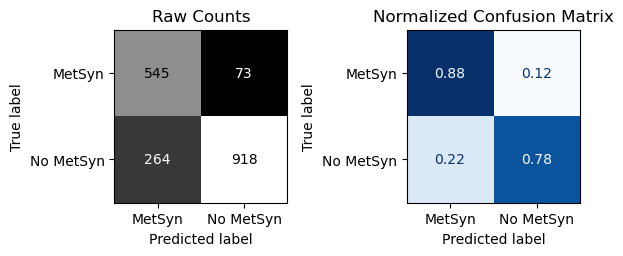


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.66      0.85      0.74       204
   No MetSyn       0.91      0.78      0.84       397

    accuracy                           0.80       601
   macro avg       0.79      0.81      0.79       601
weighted avg       0.83      0.80      0.81       601



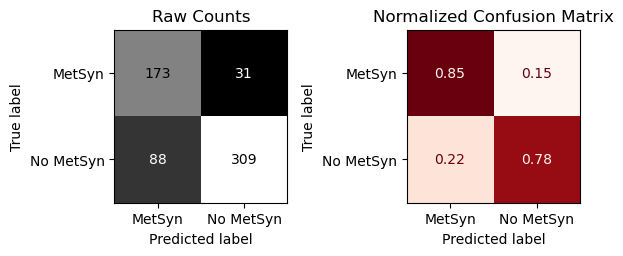

In [29]:
evaluate_classification(gs_knn_smote.best_estimator_, X_train, y_train, X_test, y_test)

**inspecting results on testing data after verifying that the variance is accepted between training and testing data:**

- an increase in MetSyn Recall from 78% to 85%
- a decrease of the false negatives from 22% to 15%
- Macro avrg for Recall has changed from 78% to 81%


---

this model has used 29 Kneighbours

# importances extraction

## imports and function

In [30]:
from sklearn.inspection import permutation_importance
# pd.set_option('display.float_format', lambda x: f"{x:,.2f}")

In [31]:
def plot_importance_color_ax(importances, top_n=None,  figsize=(8,6),
                          color_dict=None, ax=None):

    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)

    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize, ax=ax)

    # set titles and axis labels
    ax.set(xlabel='Importance',
           ylabel='Feature Names',
           title=title)

    ## return ax in case want to continue to update/modify figure
    return ax

##################

## permutated importances

- since our best model parameters were 29 Kneighbours, i will make a new variable with this parameter and extract importances using it

In [32]:
knn_29 = KNeighborsClassifier(n_neighbors=29)

knn29_smote_pipe = make_sampler_pipeline(preprocessor, smote,  knn_29)

knn29_smote_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Income', 'WaistCirc', 'BMI', 'Albuminuria', 'UrAlbCr',
       'UricAcid', 'BloodGlucose', 'HDL', 'Triglycerides'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000023540258E80>)],
                                   verbose_feature_names_out=False)),
                ('smote', SMOTE(random_state=42)),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=29))])

In [36]:
permutation_importances = permutation_importance(knn29_smote_pipe , X_test, y_test, n_repeats=5, random_state=42)


In [37]:
permutation_importances

{'importances_mean': array([ 0.03427621,  0.01464226,  0.01364393,  0.00332779,  0.00698835,
         0.02462562,  0.01464226,  0.00698835,  0.00133111, -0.00066556,
         0.04392679,  0.03527454,  0.05657238]),
 'importances_std': array([0.01039634, 0.00322641, 0.00617213, 0.00622572, 0.00570597,
        0.00685233, 0.00660547, 0.00486813, 0.0022074 , 0.00653806,
        0.00670531, 0.00876668, 0.00729082]),
 'importances': array([[ 0.04326123,  0.04326123,  0.03327787,  0.01497504,  0.03660566],
        [ 0.01164725,  0.01663894,  0.01663894,  0.00998336,  0.01830283],
        [ 0.00998336,  0.00499168,  0.02329451,  0.01663894,  0.01331115],
        [ 0.        , -0.00332779,  0.00332779,  0.01497504,  0.00166389],
        [ 0.00166389,  0.01164725,  0.01497504,  0.        ,  0.00665557],
        [ 0.01996672,  0.02163062,  0.02163062,  0.03826955,  0.02163062],
        [ 0.01663894,  0.00665557,  0.00831947,  0.01663894,  0.0249584 ],
        [ 0.00166389,  0.01497504,  0.003327

In [38]:
permutation_importances = pd.Series(permutation_importances['importances_mean'],index=X_test.columns,
                           name = 'permutation importance')

In [39]:
permutation_importances = permutation_importances.sort_values(ascending=False)

permutation_importances

Triglycerides    0.056572
BloodGlucose     0.043927
HDL              0.035275
Age              0.034276
WaistCirc        0.024626
Sex              0.014642
BMI              0.014642
Marital          0.013644
Race             0.006988
Albuminuria      0.006988
Income           0.003328
UrAlbCr          0.001331
UricAcid        -0.000666
Name: permutation importance, dtype: float64

<Axes: title={'center': 'Top 15 Most Important Features'}, xlabel='Importance', ylabel='Feature Names'>

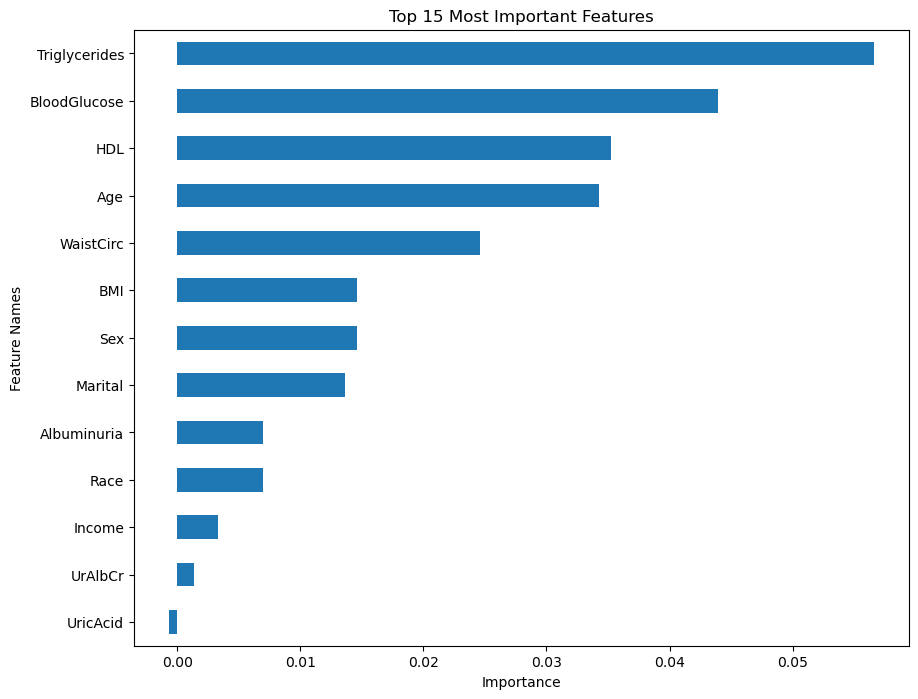

In [40]:
n = 15
plot_importance_color_ax(permutation_importances, top_n=n,
                         figsize=(10,8))

### permutation from transformed(processed) data

In [41]:
permutation_importances_tf = permutation_importance(knn_29 , X_test_tf, y_test, n_repeats=5, random_state=42)
permutation_importances_tf


{'importances_mean': array([ 0.03427621,  0.00332779,  0.02462562,  0.01464226,  0.00698835,
         0.00133111, -0.00066556,  0.04392679,  0.03527454,  0.05657238,
         0.01464226,  0.00998336,  0.00066556,  0.00499168,  0.00166389,
         0.0093178 ,  0.00099834, -0.00033278,  0.        ,  0.00831947]),
 'importances_std': array([0.01039634, 0.00622572, 0.00685233, 0.00660547, 0.00486813,
        0.0022074 , 0.00653806, 0.00670531, 0.00876668, 0.00729082,
        0.00322641, 0.00278423, 0.00169685, 0.00148823, 0.00148823,
        0.00342617, 0.00225701, 0.00124514, 0.        , 0.00526169]),
 'importances': array([[ 0.04326123,  0.04326123,  0.03327787,  0.01497504,  0.03660566],
        [ 0.        , -0.00332779,  0.00332779,  0.01497504,  0.00166389],
        [ 0.01996672,  0.02163062,  0.02163062,  0.03826955,  0.02163062],
        [ 0.01663894,  0.00665557,  0.00831947,  0.01663894,  0.0249584 ],
        [ 0.00166389,  0.01497504,  0.00332779,  0.00998336,  0.00499168],
   

In [42]:
permutation_importances_tf = pd.Series(permutation_importances_tf['importances_mean'],index=X_test_tf.columns,
                           name = 'permutation importance')

<Axes: title={'center': 'Top 15 Most Important Features'}, xlabel='Importance', ylabel='Feature Names'>

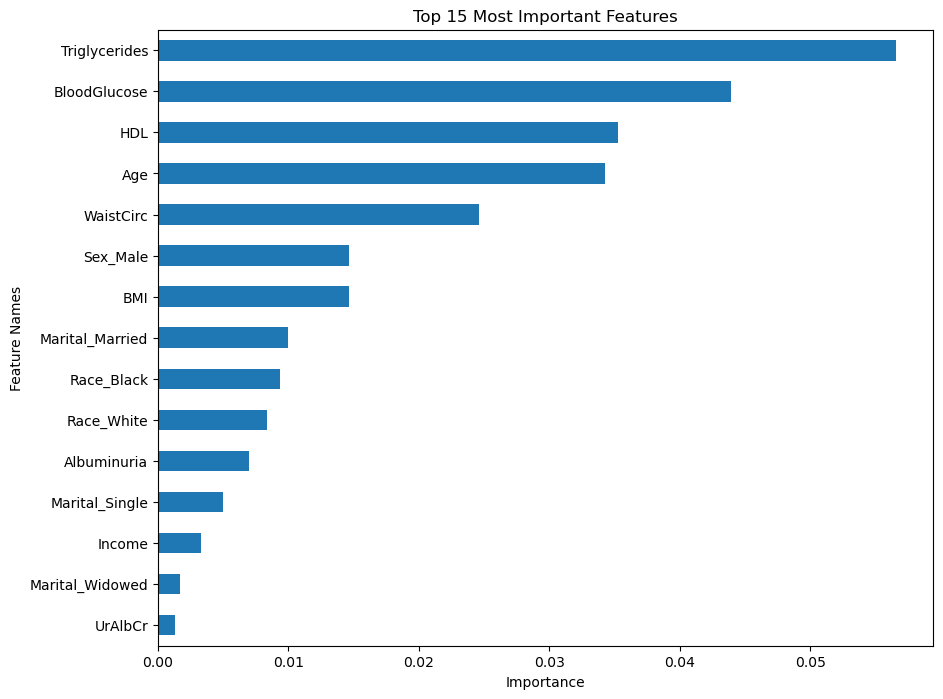

In [43]:
plot_importance_color_ax(permutation_importances_tf, top_n=n,
                         figsize=(10,8))

# Visualizing important features for the model we've chosen to work with

- lets concate our processed df in order to work with what singled out categories

---

In [44]:
plot_df_train = pd.concat([X_train_tf, y_train],axis=1)
plot_df_test = pd.concat([X_test_tf, y_test],axis=1)
plot_df = pd.concat([plot_df_train, plot_df_test])
plot_df.head()

,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,Sex_Male,Marital_Married,Marital_Separated,Marital_Single,Marital_Widowed,Race_Black,Race_Hispanic,Race_MexAmerican,Race_Other,Race_White,MetabolicSyndrome
seqn,,,,,,,,,,,,,,,,,,,,,
63211,-0.176875,1.443579,1.591313,1.815754,-0.366397,-0.100646,-1.503810,0.962189,-0.045041,0.728110,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,MetSyn
70548,-0.857407,-0.165173,-0.767163,-0.637064,-0.366397,-0.108892,0.406271,0.185052,1.929154,-0.704544,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,No MetSyn
64722,-0.914117,-0.165173,-1.465971,-0.561824,-0.366397,-0.125171,-1.435593,-0.323077,-0.637299,-0.704544,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,No MetSyn
69237,-0.006742,1.717409,-0.174425,0.687157,-0.366397,-0.152526,-1.913113,-0.562196,-0.176654,0.115599,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,No MetSyn
65286,-1.084250,1.717409,-1.422296,-1.028311,-0.366397,-0.138548,1.088443,-0.801315,0.283992,2.762893,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No MetSyn


In [45]:
plot_df['MetabolicSyndrome_num'] = plot_df['MetabolicSyndrome'].replace({'MetSyn': 1, 'No MetSyn': 0})
plot_df.head()

,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,Sex_Male,Marital_Married,Marital_Separated,Marital_Single,Marital_Widowed,Race_Black,Race_Hispanic,Race_MexAmerican,Race_Other,Race_White,MetabolicSyndrome,MetabolicSyndrome_num
seqn,,,,,,,,,,,,,,,,,,,,,,
63211,-0.176875,1.443579,1.591313,1.815754,-0.366397,-0.100646,-1.503810,0.962189,-0.045041,0.728110,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,MetSyn,1
70548,-0.857407,-0.165173,-0.767163,-0.637064,-0.366397,-0.108892,0.406271,0.185052,1.929154,-0.704544,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,No MetSyn,0
64722,-0.914117,-0.165173,-1.465971,-0.561824,-0.366397,-0.125171,-1.435593,-0.323077,-0.637299,-0.704544,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,No MetSyn,0
69237,-0.006742,1.717409,-0.174425,0.687157,-0.366397,-0.152526,-1.913113,-0.562196,-0.176654,0.115599,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,No MetSyn,0
65286,-1.084250,1.717409,-1.422296,-1.028311,-0.366397,-0.138548,1.088443,-0.801315,0.283992,2.762893,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No MetSyn,0


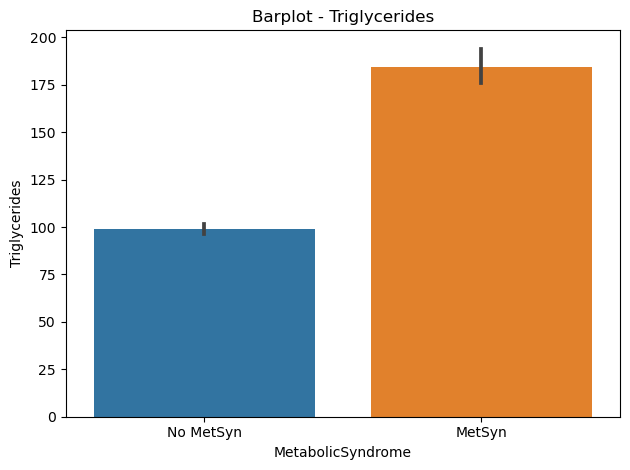

<Figure size 640x480 with 0 Axes>

In [46]:
sns.barplot(data=df, x='MetabolicSyndrome',y='Triglycerides');


plt.title("Barplot - Triglycerides")
plt.xlabel("MetabolicSyndrome")
plt.ylabel("Triglycerides")
plt.tight_layout()
plt.show()
plt.savefig('MSvsTrig.png')

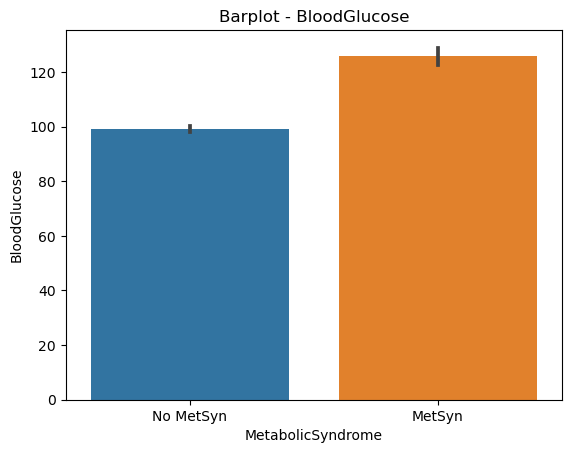

<Figure size 640x480 with 0 Axes>

In [47]:
sns.barplot(data=df, x='MetabolicSyndrome',y='BloodGlucose');

plt.title("Barplot - BloodGlucose")
plt.xlabel("MetabolicSyndrome")
plt.ylabel("BloodGlucose")
plt.show()
plt.tight_layout()
plt.savefig('MSvsBloodG.png')